In [31]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
from pathlib import Path
import scipy.stats as stats

In [32]:
def compute_entropy_from_singular_values(singular_values, threshold=1e-10):
    """Compute von Neumann entropy from singular values."""
    sv_clipped = np.maximum(singular_values, threshold)
    eigenvalues = sv_clipped**2
    
    if len(eigenvalues) > 0:
        return -np.sum(eigenvalues * np.log(eigenvalues))
    return 0.0

def process_p_values_for_system_size(h5_file_path, dataset_path='pctrl0.400/singular_values/AB'):
    """
    Extract entropy vs p-value data for a single system size.
    
    Returns:
    --------
    dict: {'L': L, 'p_values': array, 'mean_entropies': array, 'sem_entropies': array}
    """
    with h5py.File(h5_file_path, 'r') as f:
        if dataset_path not in f:
            print(f"Warning: {dataset_path} not found in {h5_file_path}")
            return None
        
        # Get system size from filename
        L = int(str(h5_file_path).split('_L')[-1].split('.')[0])
        
        # Find the parameter group (e.g., 'pctrl0.400')
        param_group_key = dataset_path.split('/')[0]  # e.g., 'pctrl0.400'
        param_group = f[param_group_key]
        
        # Get p-values (the varying parameter)
        # Determine which parameter is varying
        if 'pctrl' in param_group_key:
            # p_ctrl is fixed, p_proj is varying
            p_values = np.array(param_group['pproj'])
        else:
            # p_proj is fixed, p_ctrl is varying
            p_values = np.array(param_group['pctrl'])
        
        # Get singular values dataset
        sv_dataset = f[dataset_path]
        data_shape = sv_dataset.shape
        n_p_values, n_ensembles = data_shape[0], data_shape[1]
        
        mean_entropies = []
        sem_entropies = []
        
        # For each p-value
        for p_idx in range(n_p_values):
            # Get all ensembles for this p-value
            p_data = np.array(sv_dataset[p_idx])  # shape: (n_ensembles, n_singular_values)
            
            # Compute entropy for each ensemble
            ensemble_entropies = [
                compute_entropy_from_singular_values(sv_array) 
                for sv_array in p_data
            ]

            ensemble_entropies = np.array(ensemble_entropies)
            # Statistics across ensembles
            mean_entropy = np.mean(ensemble_entropies)
            sem_entropy = np.std(ensemble_entropies) / np.sqrt(len(ensemble_entropies))
            # sem_entropy = stats.sem(ensemble_entropies)
            
            mean_entropies.append(mean_entropy)
            sem_entropies.append(sem_entropy)
        
        return {
            'L': L,
            'p_values': p_values,
            'mean_entropies': np.array(mean_entropies),
            'sem_entropies': np.array(sem_entropies)
        }


In [33]:
def plot_entropy_vs_p_values(file_paths, dataset_path='pctrl0.400/singular_values/AB', 
                             title="von Neumann Entropy vs P-values", figsize=(12, 8), bound_p=0.5, save_data = True):
    """
    Plot entropy vs p-values with one line for each system size L.
    
    Parameters:
    -----------
    file_paths : dict
        Dictionary {L: 'path/to/file_L{L}.h5'} or list of file paths
    dataset_path : str
        Path to dataset within HDF5 files
    title : str
        Plot title
    figsize : tuple
        Figure size
    
    Returns:
    --------
    dict: Results for each system size
    """
    results = {}
    
    # Handle both dict and list inputs
    if isinstance(file_paths, dict):
        items = file_paths.items()
    else:
        # Extract L from filename
        items = [(int(str(f).split('_L')[-1].split('.')[0]), f) for f in file_paths]
    
    # Process each system size
    for L, file_path in items:
        print(f"Processing L={L}...")
        result = process_p_values_for_system_size(file_path, dataset_path)
        if result is not None:
            results[L] = result
    
    if not results:
        print("No data to plot!")
        return results
    
    # Create the plot
    plt.figure(figsize=figsize)
    
    # Use different colors for different system sizes
    colors = plt.cm.Set1(np.linspace(0, 1, len(results)))
    
    for (L, data), color in zip(sorted(results.items()), colors):
        p_values = data['p_values']
        mean_entropies = data['mean_entropies'] / np.log(L)
        sem_entropies = data['sem_entropies'] / np.log(L)
        print(p_values.shape, mean_entropies.shape, sem_entropies.shape)

        if save_data:
            np.savez(f'/scratch/ty296/CT_toy/entropy_vs_p_values_L{L}.npz', p_values=p_values, mean_entropies=mean_entropies, sem_entropies=sem_entropies)
            print(f'Saved data for L={L}')
        # Plot line with error bars
        # Only plot p_values > 0.5
        mask = p_values > bound_p
        p_values = p_values[mask]
        mean_entropies = mean_entropies[mask]
        sem_entropies = sem_entropies[mask]
        plt.errorbar(p_values, mean_entropies, yerr=sem_entropies,
                    marker='o', markersize=6, capsize=4, capthick=1.5,
                    linewidth=2, alpha=0.8, color=color, 
                    label=f'L={L}', linestyle='-')
    
    plt.xlabel('P-value', fontsize=14)
    plt.ylabel('von Neumann Entropy', fontsize=14)
    plt.title(title, fontsize=16, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    return results


Found files: ['CT_toy/sv_fine_L20_pproj0.643_pc0.473/final_results_L20.h5', 'CT_toy/sv_fine_L8_pproj0.750_pc0.25/final_results_L8.h5', 'CT_toy/sv_comparison_L12_pctrl0.400_pc0.800/final_results_L12.h5', 'CT_toy/sv_L12_pctrl0.400_p0.000-1.000/final_results_L12.h5', 'CT_toy/sv_fine_L20_pproj0.571_pc0.49/final_results_L20.h5', 'CT_toy/sv_fine_L8_pproj0.000_pc0.453/final_results_L8.h5', 'CT_toy/sv_L12_pctrl0.400_p0.500-1.000/final_results_L12.h5', 'CT_toy/sv_fine_L8_pproj0.500_pc0.5/final_results_L8.h5', 'CT_toy/sv_fine_L12_pproj0.000_pc0.453/final_results_L12.h5', 'CT_toy/sv_L8_pctrl0.400_p0.500-1.000/final_results_L8.h5', 'CT_toy/sv_fine_L12_pproj0.750_pc0.25/final_results_L12.h5', 'CT_toy/sv_fine_L12_pproj0.643_pc0.473/final_results_L12.h5', 'CT_toy/sv_fine_L16_pproj0.750_pc0.25/final_results_L16.h5', 'CT_toy/sv_fine_L20_pproj0.000_pc0.45/final_results_L20.h5', 'CT_toy/sv_comparison_L8_pctrl0.000_p0.400-0.600/final_results_L8.h5', 'CT_toy/sv_L16_pctrl0.400_p0.000-1.000/final_results_L16

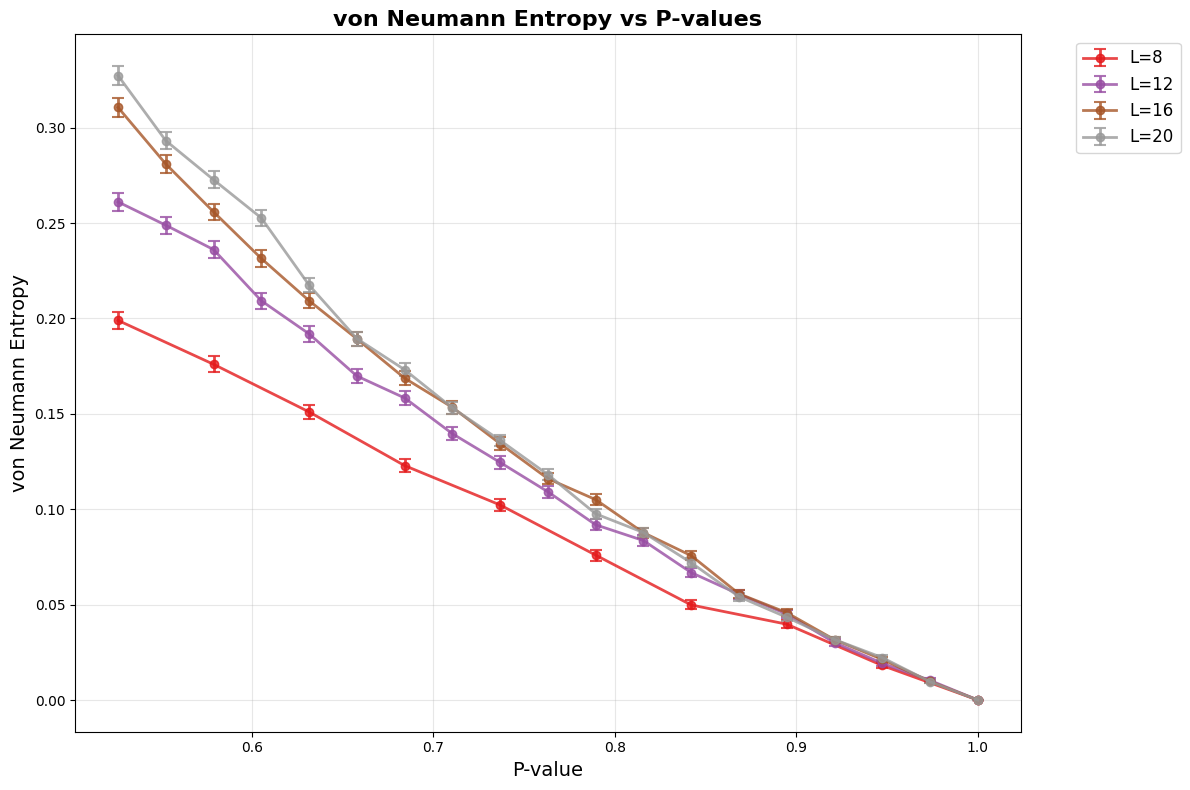

In [34]:
# Example 2: Auto-discover files with glob
from glob import glob

# Find all HDF5 files matching pattern
h5_files = glob('**/final_results_L*.h5', recursive=True)
print(f"Found files: {h5_files}")

# Plot using the list of files (if found)
if h5_files:
    results = plot_entropy_vs_p_values(h5_files, 
                                       dataset_path='pctrl0.400/singular_values/AB')


In [35]:
# # SIMPLEST USAGE - Just change your file paths!
# files = {
#     8: '/scratch/ty296/CT_toy/sv_L8_pctrl0.400_p0.000-1.000/final_results_L8.h5',
#     12: '/scratch/ty296/CT_toy/sv_L12_pctrl0.400_p0.000-1.000/final_results_L12.h5', 
#     16: '/scratch/ty296/CT_toy/sv_L16_pctrl0.400_p0.000-1.000/final_results_L16.h5',
# }

# # That's it! One function call for the complete analysis:
# results = plot_entropy_vs_p_values(files)


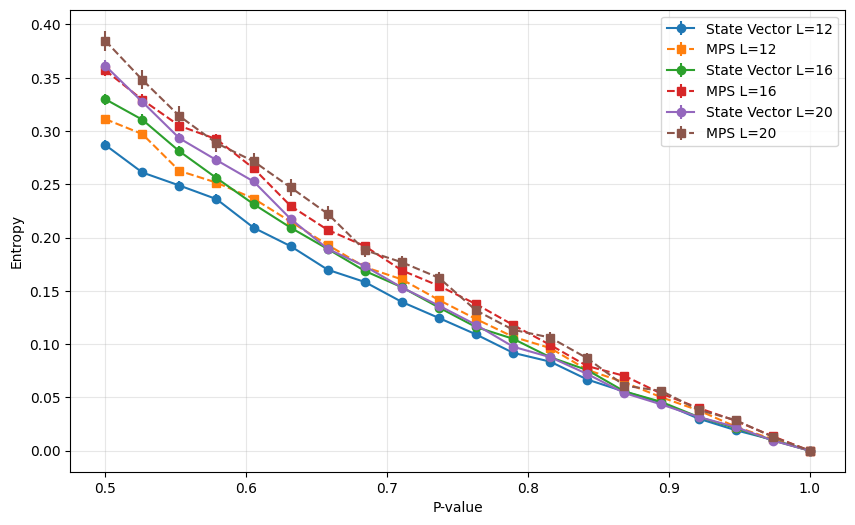

In [39]:
# Comparing MPS and state vector evolution
import numpy as np
import matplotlib.pyplot as plt

# Load data
L_arr = [12, 16, 20]
p_bound = 0.5
plt.figure(figsize=(10, 6))

for L in L_arr:
    data_path_py = f'/scratch/ty296/CT_toy/entropy_vs_p_values_L{L}.npz'
    data_py = np.load(data_path_py)
    p_values_py = data_py['p_values']
    mask_py = p_values_py >= p_bound
    p_values_py = p_values_py[mask_py]
    mean_entropies_py = data_py['mean_entropies'][mask_py]
    sem_entropies_py = data_py['sem_entropies'][mask_py]

    data_path_mps = f'/scratch/ty296/CT_MPS_mini/entropy_vs_p_values_L{L}.npz'
    data_mps = np.load(data_path_mps)
    p_values_mps = data_mps['p_values']
    mask_mps = p_values_mps >= p_bound
    p_values_mps = p_values_mps[mask_mps]
    mean_entropies_mps = data_mps['mean_entropies'][mask_mps]
    sem_entropies_mps = data_mps['sem_entropies'][mask_mps]

    # Plot
    plt.errorbar(p_values_py, mean_entropies_py, yerr=sem_entropies_py, 
                label=f'State Vector L={L}', linestyle='-', marker='o')
    plt.errorbar(p_values_mps, mean_entropies_mps, yerr=sem_entropies_mps, 
                label=f'MPS L={L}', linestyle='--', marker='s')

plt.xlabel('P-value')
plt.ylabel('Entropy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()